<a href="https://colab.research.google.com/github/pahdsn/ati_sense_hackathon/blob/master/HarryCode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# Installations

!pip install geopandas
!pip install rasterio

     |████████████████████████████████| 972kB 5.3MB/s 
     |████████████████████████████████| 14.8MB 323kB/s 
     |████████████████████████████████| 6.5MB 37.5MB/s 
     |████████████████████████████████| 19.1MB 259kB/s 


In [42]:
# Imports

import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import pandas as pd
import rasterio
import os
import glob
from google.colab import drive
import gdal
from shapely.geometry import Point
from PIL import Image
from tqdm import tqdm
from torch.utils.data import Dataset
from torchvision import transforms
import torch
import torch.nn as nn

In [9]:
# Mount Drive and set up paths

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Polar_Hack')
SAMPLING_DIR = "./samples/"
META_DIR = "./samples_meta/"
SHAPEFILE_DIR = "./EE_Polar_Training_Dataset_v-1-0-0/Sea_Ice/" 
TIFF_DIR = "./Sentinel geotiffs/"

shapefiles = glob.glob(SHAPEFILE_DIR+'*.shp')
images = glob.glob(TIFF_DIR+'*.tif')

Mounted at /content/drive


In [10]:
# Define routine for extracting label on subset of image

def get_id(shapefile):
  '''
  Extracts datetime component of name
  '''
  return shapefile.split("_")[-1][:-4].upper()

def geo_ref(x,y,GT):
  '''
  return georeferenced point from pixel coordinates
  '''
  X_geo = GT[0] + x * GT[1] + y * GT[2]
  Y_geo = GT[3] + x * GT[4] + y * GT[5]
  return Point(X_geo, Y_geo)

def sample(shapefile,x,y,N):
  '''
  Find tiff file, create NxN sample with origin (x,y) in pixel coordinates
  Return id, sample and class from shapefile
  '''
  id = get_id(shapefile)
  shape_data = gpd.read_file(shapefile)
  tiff =  gdal.Open([g for g in images if id in g][0])
  point = geo_ref(x+N/2,y+N/2,tiff.GetGeoTransform())
  i=0
  classification = None
  while i < shape_data.shape[0] and classification == None:
    if shape_data['geometry'][i].contains(point):
      classification = shape_data['poly_type'][i]
    i += 1
  if classification != None:
    im = Image.fromarray(np.transpose(tiff.ReadAsArray()[:,x:x+N,y:y+N],(1,2,0)))
    image_name = SAMPLING_DIR+id+'X'+str(x)+'Y'+str(y)+'.png'
    im.save(image_name)
    return id, classification, image_name
  else:
    return None, None, None

In [11]:
# Raw image dimensions
xx = 15564
yy = 15218

def get_samples(grid_space, sample_size):
  '''
  Grid space - how densely to sample the raw S1 images
  sample size - size of square sample images (both in pixels)
  Saves sample images in png format and metadata as csv file
  '''
  metadata = pd.DataFrame(columns=['id','x','y','label','image'])
  for S in tqdm(shapefiles):
    for x in np.arange(2*grid_space,xx-2*grid_space,grid_space):
      for y in np.arange(2*grid_space,yy-2*grid_space,grid_space):
        id, label, name = sample(S,x,y,sample_size)
        if label != None:
          metadata = metadata.append({'id':id,'x':x,'y':y,'label':label,'image':name},ignore_index=True)
    metadata.to_csv(META_DIR+'samples.csv')
  return metadata

In [31]:
LABELS = {
	"L": 0,
	"W": 1,
	"I": 2,
}
samples = pd.read_csv(META_DIR+'samples.csv',usecols=['id','x','y','label','image'])
samples['label'] = [LABELS.get(ll) for ll in samples['label']]
samples.head()

,id,x,y,label,image
0,20180814T075344,1500,9000,0,./samples/20180814T075344X1500Y9000.png
1,20180814T075344,1500,9500,2,./samples/20180814T075344X1500Y9500.png
2,20180814T075344,2000,8000,2,./samples/20180814T075344X2000Y8000.png
3,20180814T075344,2000,8500,2,./samples/20180814T075344X2000Y8500.png
4,20180814T075344,2000,9000,2,./samples/20180814T075344X2000Y9000.png


In [61]:
samples.values[:,4]


array(['./samples/20180814T075344X1500Y9000.png',
       './samples/20180814T075344X1500Y9500.png',
       './samples/20180814T075344X2000Y8000.png', ...,
       './samples/20180213T175444X14500Y11500.png',
       './samples/20180213T175444X14500Y12000.png',
       './samples/20180213T175444X14500Y12500.png'], dtype=object)

In [62]:
# Set up data for torch

TRAIN_SIZE = 0.7

class PolarPatch(Dataset):
    '''
    TorchUtils dataset
    '''
    def __init__(self, transform=None, split="train"):
        super(PolarPatch, self).__init__()

        assert split in ["train", "val"]
        
        # TODO: load in meta data, which should be of shape (3, N) - N being the number of samples
        meta = samples.values

        train_dim = int(TRAIN_SIZE * len(meta))
        
        if split == "train":
            meta = meta[:train_dim]
        else:
            meta = meta[train_dim:]                   
        self.images = meta[:,4]
        self.coords = [(row[1], row[2]) for row in meta]

        # Targets in integer form for computing cross entropy
        self.targets = meta[:,3]
        self.transform = transform


    def __len__(self):
        return len(self.targets)

    def __getitem__(self, index):

        x = Image.open(self.images[index]) # change this file format if needed
        y = self.targets[index]
        coord = self.coords[index]

        if self.transform:
        	x = self.transform(x)

        return x, y, coord


In [73]:
BATCH_SIZE = 128

data_transform = transforms.Compose([
    # TODO: add whatever else you need - normalisation, augmentation, etc.
	transforms.ToTensor(),
])

train_set = PolarPatch(
    split='train',
    transform=data_transform
)

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_set = PolarPatch(
    split='val',
    transform=data_transform
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)



In [84]:
# nn i torch neural network class
# Create a specific nn for our purposes called PolarNet

class PolarNet(nn.Module): # nn.Module is base class for all networks
    def __init__(self, n_classes=3):
        super(PolarNet, self).__init__()
# Super means inherit attributes, presumably from nn.Module
        self.features = nn.Sequential(
            # TODO: build your own architecture here; one conv layer and ReLU here as an example only
            nn.Conv2d(3, 16, kernel_size=5, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2),
            nn.Conv2d(16,32,kernel_size=5,padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2,2),stride=2)
        ) # 13*13 * 32 = 5408 pixels

        self.classifier = nn.Sequential(
            nn.Linear(5408,36),
            nn.ReLU(), 
            nn.Linear(36, 3)
        )      

    def forward(self, x):
        # as an example; alter as needed depending on your architecture
        x = self.features(x)

        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [85]:
# Device configuration - defaults to CPU unless GPU is available on device
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = PolarNet().to(DEVICE)
loss_fn = nn.CrossEntropyLoss()

# Stochastic Gradient Descent
optimizer = torch.optim.SGD(
	model.parameters(),
	lr=0.001,
	weight_decay=0.0005,
	momentum=0.9,
)

In [91]:
'''
David Hogg's functions (modified) for capturing the stats during training
'''

def stats(loader, net):
    correct = 0
    total = 0
    running_loss = 0
    n = 0
    with torch.no_grad():
        for data in loader:
            images, labels, coords = data
            images = images.to(DEVICE)
            labels = labels.to(DEVICE)
            outputs = net.forward(images)
            loss = loss_fn(outputs, labels)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)    # add in the number of labels in this minibatch
            correct += (predicted == labels).sum().item()  # add in the number of correct labels
            running_loss += loss
            n += 1
    return running_loss/n, correct/total 

def statsplot(statsrec,name):
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[1], 'g', label = 'test loss' )
    plt.legend(loc='center')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[2], 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper left')
    plt.savefig('./figures/'+name+'.png')
    plt.show()
    

## Training

In [ ]:
nepochs = 10
# How many times go through the full training dataset

statsrec = np.zeros((3,nepochs))
# Numy array for holding some results

for epoch in range(nepochs):  # loop over the dataset multiple times

    running_loss = 0.0
    n = 0
    for i, data in enumerate(train_loader, 0):
        inputs, labels, coords = data
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
         # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward, backward, and update parameters
        outputs = model.forward(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
    
        # accumulate loss
        running_loss += loss.item()
        n += 1
    
    ltrn = running_loss/n
    ltst, atst = stats(test_loader, model)
    statsrec[:,epoch] = (ltrn, ltst, atst)
    print(f"epoch: {epoch} training loss: {ltrn: .3f}  test loss: {ltst: .3f} test accuracy: {atst: .1%}")

print('********** Finished Training ***************')

epoch: 0 training loss:  0.762  test loss:  0.870 test accuracy:  69.0%
epoch: 1 training loss:  0.695  test loss:  0.801 test accuracy:  73.1%
epoch: 2 training loss:  0.644  test loss:  0.776 test accuracy:  73.2%


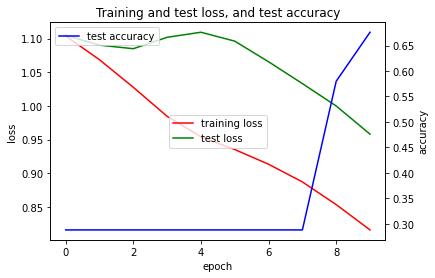

In [92]:
statsplot(statsrec,'5408_secondrun')